In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

### 1. 데이터 준비

In [4]:
!gdown  https://drive.google.com/uc?id=1-RBvPOYycsSpS7rVP0Pqwcbh18lZYDeb

Downloading...
From: https://drive.google.com/uc?id=1-RBvPOYycsSpS7rVP0Pqwcbh18lZYDeb
To: /content/BBRegression.zip
100% 945k/945k [00:00<00:00, 8.39MB/s]


In [5]:
!unzip BBRegression.zip

Archive:  BBRegression.zip
replace BBRegression/README.dataset.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [6]:
IMAGE_PATH = '/content/BBRegression'

In [7]:
# xmin, ymin, xmax, ymax 구하기
import glob
import xml.etree.ElementTree as ET

def xml_to_csv(path):
    xml_list = []
    for xml_file in glob.glob(path + '/*.xml'):

        tree = ET.parse(xml_file)
        root = tree.getroot()
        for member in root.findall('object'):
            bbx = member.find('bndbox')
            xmin = int(bbx.find('xmin').text)
            ymin = int(bbx.find('ymin').text)
            xmax = int(bbx.find('xmax').text)
            ymax = int(bbx.find('ymax').text)
            label = member.find('name').text

            value = (root.find('filename').text,
                     int(root.find('size')[0].text),
                     int(root.find('size')[1].text),
                     label,
                     xmin,
                     ymin,
                     xmax,
                     ymax
                     )
            xml_list.append(value)
    column_name = ['filename', 'width', 'height',
                   'class', 'xmin', 'ymin', 'xmax', 'ymax']
    xml_df = pd.DataFrame(xml_list, columns=column_name)
    return xml_df

In [8]:
import os

FILE_NAME = 'label_cats.csv'

csv_path = os.path.join(IMAGE_PATH, 'train')
xml_df = xml_to_csv(csv_path)

In [9]:
xml_df.head()

,filename,width,height,class,xmin,ymin,xmax,ymax
0,cat-228_jpg.rf.eb6e6c9bef4948fc0ef34fa69bfeec1...,224,224,cat,40,2,105,70
1,cat-133_jpg.rf.f28aa24b4ef0b965447ef52fb739f23...,224,224,cat,53,2,140,112
2,cat-181_jpg.rf.e09964d5292e4128ef99db46b0b352c...,224,224,cat,47,9,207,125
3,cat-122_jpg.rf.f191c6eca98a6d3a361d47722a29bf8...,224,224,cat,84,3,209,102
4,cat-269_jpg.rf.86974c2fb78b7470205d358c53f7055...,224,224,cat,96,3,200,85


In [10]:
images = xml_df['filename'].values
images[:5]

array(['cat-228_jpg.rf.eb6e6c9bef4948fc0ef34fa69bfeec18.jpg',
       'cat-133_jpg.rf.f28aa24b4ef0b965447ef52fb739f233.jpg',
       'cat-181_jpg.rf.e09964d5292e4128ef99db46b0b352c7.jpg',
       'cat-122_jpg.rf.f191c6eca98a6d3a361d47722a29bf8f.jpg',
       'cat-269_jpg.rf.86974c2fb78b7470205d358c53f7055b.jpg'],
      dtype=object)

In [11]:
points = xml_df.iloc[:, 4:].values
points[:5]

array([[ 40,   2, 105,  70],
       [ 53,   2, 140, 112],
       [ 47,   9, 207, 125],
       [ 84,   3, 209, 102],
       [ 96,   3, 200,  85]])

In [12]:
import PIL

dataset_images = []
dataset_bbs = []

for file, point in zip(images, points):
    f = os.path.join(IMAGE_PATH, 'train', file)
    image = PIL.Image.open(f)
    arr = np.array(image)
    dataset_images.append(arr)
    dataset_bbs.append(point)

In [13]:
np.array(dataset_bbs)

array([[ 40,   2, 105,  70],
       [ 53,   2, 140, 112],
       [ 47,   9, 207, 125],
       [ 84,   3, 209, 102],
       [ 96,   3, 200,  85],
       [ 76,   2, 166, 120],
       [  5,  21, 113, 152],
       [ 34,   1, 204,  87],
       [ 59,  28, 215, 178],
       [ 70,  14, 181, 105],
       [ 24,  32, 218, 163],
       [ 10,  18,  91, 152],
       [ 36,   9, 159, 123],
       [ 16,  12,  91, 121],
       [ 47,   1, 208,  93],
       [ 82,  17, 150,  95],
       [ 33,   7, 148,  71],
       [ 90,   5, 195, 168],
       [ 78,   2, 210, 149],
       [ 58,  19, 132, 111],
       [ 85,  10, 194, 145],
       [ 60,  36, 157, 160],
       [ 29,  34,  89, 146],
       [103,   3, 216, 132],
       [ 28,  24, 148, 136],
       [ 52, 142, 156, 224],
       [ 30,  19, 215, 193],
       [113,  34, 207, 125],
       [ 23,  12, 183, 174],
       [ 46,  30, 142, 152],
       [ 32,  34, 122, 129],
       [ 28,  18, 126, 103],
       [ 17,  10, 197, 182],
       [ 30,  15, 205, 156],
       [ 41,  

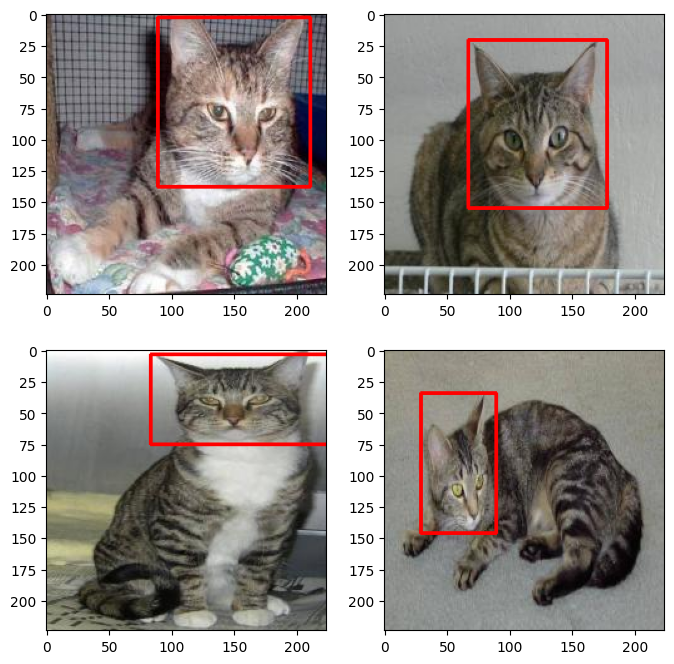

In [14]:
import cv2

samples = np.random.randint(91, size=4)

plt.figure(figsize=(8, 8))
for i, idx in enumerate(samples):
    points = dataset_bbs[idx].reshape(2, 2)
    img = cv2.rectangle(dataset_images[idx].copy(),
                        tuple(points[0]),
                        tuple(points[1]),
                        color=(255, 0, 0),
                        thickness=2)
    plt.subplot(2, 2, i+1)
    plt.imshow(img)
plt.show()

In [15]:
# 중간 처리 이미지 데이터 저장

np.savez('cat_bbs.npz',
         images = dataset_images,
         bbs = dataset_bbs)

In [16]:
# npz 파일 다시 읽어올 때

dataset = np.load('cat_bbs.npz')

In [17]:
X = dataset['images']
y = dataset['bbs']

X.shape, y.shape

((91, 224, 224, 3), (91, 4))

* 데이터 정규화

In [18]:
X_train = X.copy()
y_train = y.copy()

In [19]:
X_train_s = X_train.astype('float32')/255.

### 2. 모델 만들기

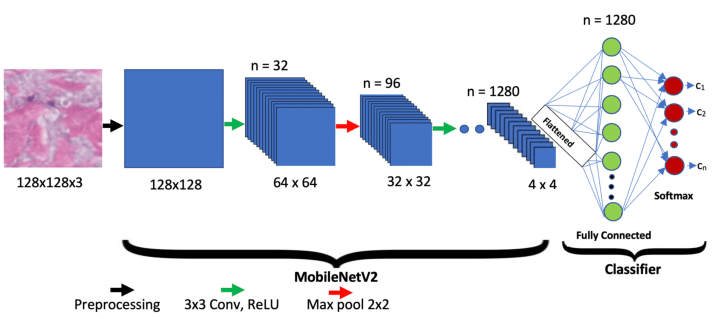

In [20]:
from keras.applications import MobileNetV2

base = MobileNetV2(
    input_shape = (224, 224, 3),
    include_top = False,
    weights = 'imagenet'
)
base.trainable = False

In [21]:
base.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[

In [22]:
from keras import layers

model = keras.Sequential([
    base,
    layers.Flatten(),
    layers.Dense(128, activation = 'relu'),
    layers.Dense(64, activation = 'relu'),
    layers.Dense(4)
])

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 flatten (Flatten)           (None, 62720)             0         
                                                                 
 dense (Dense)               (None, 128)               8028288   
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 4)                 260       
                                                                 
Total params: 10294788 (39.27 MB)
Trainable params: 8036804 (30.66 MB)
Non-trainable params: 2257984 (8.61 MB)
___________

In [24]:
model.compile(
    optimizer = 'adam',
    loss = 'mse', #회귀는 mse
    metrics = ['mse']
)

### 3. 학습하기

In [25]:
from keras.callbacks import ModelCheckpoint
ckpt_path = '/ckpt/cats_bbs.ckpt'
ckpt_cb = ModelCheckpoint(
    ckpt_path,
    save_weights_only = True,
    save_best_only = True,
    monitor = 'val_loss'
)

In [28]:
EPOCHS = 30
BATCH_SIZE = 16

history = model.fit(
    X_train_s, y_train,
    epochs = EPOCHS,
    batch_size = BATCH_SIZE,
    validation_split = 0.2,
    callbacks = [ckpt_cb],
    verbose = 1
)

Epoch 1/30
5/5 [==============================] - 11s 1s/step - loss: 6691.3047 - mse: 6691.3047 - val_loss: 3549.7759 - val_mse: 3549.7759
Epoch 2/30
5/5 [==============================] - 4s 783ms/step - loss: 3152.4729 - mse: 3152.4729 - val_loss: 1558.8910 - val_mse: 1558.8910
Epoch 3/30
5/5 [==============================] - 5s 1s/step - loss: 1424.0453 - mse: 1424.0453 - val_loss: 1538.8353 - val_mse: 1538.8353
Epoch 4/30
5/5 [==============================] - 3s 647ms/step - loss: 786.1682 - mse: 786.1682 - val_loss: 844.3265 - val_mse: 844.3264
Epoch 5/30
5/5 [==============================] - 3s 578ms/step - loss: 424.2035 - mse: 424.2035 - val_loss: 857.0909 - val_mse: 857.0909
Epoch 6/30
5/5 [==============================] - 3s 681ms/step - loss: 261.1971 - mse: 261.1971 - val_loss: 638.5326 - val_mse: 638.5326
Epoch 7/30
5/5 [==============================] - 5s 1s/step - loss: 158.0504 - mse: 158.0504 - val_loss: 704.9048 - val_mse: 704.9048
Epoch 8/30
5/5 [==============

In [29]:
model.load_weights(ckpt_path)

### 4. 테스트

In [30]:
fnames = glob.glob('/content/BBRegression/test' + '/*.jpg')

X_test = []

for f in fnames:
    image = PIL.Image.open(f)
    arr = np.array(image)
    X_test.append(arr)

X_test = np.array(X_test)

#정규화
X_test = X_test.astype('float32')/255.
y_pred = model.predict(X_test).astype('int')

1/1 [==============================] - 1s 1s/step


In [31]:
y_pred[:10]

array([[ 38,  21, 167, 166],
       [ 67,  13, 156, 111],
       [ 47,  15, 166, 156],
       [ 67,  21, 200, 167],
       [ 49,  12, 176, 132],
       [ 72,   6, 176, 112],
       [ 73,  28, 215, 180],
       [ 55,   4, 138,  85],
       [ 48,   9, 165, 114],
       [ 54,  28, 173, 167]])

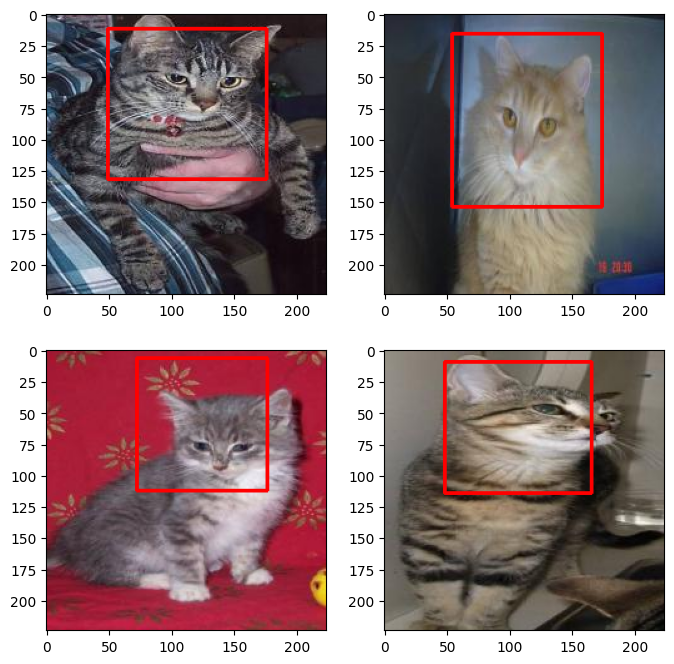

In [32]:
samples = np.random.randint(11, size=4)
plt.figure(figsize=(8, 8))

for i, idx in enumerate(samples):
    points = y_pred[idx].reshape(2, 2) #2차원으로 변경

    img = cv2.rectangle(X_test[idx].copy(), tuple(points[0]),tuple(points[1]),color=(255, 0, 0),
                        thickness=2)
    plt.subplot(2, 2, i+1)
    plt.imshow(img)

plt.show()